# Notebook for Disinformation classification with BERT

# Load the dataset

In [1]:
!pip install transformers
!pip install datasets

In [2]:
import pandas as pd

In [3]:
df_true = pd.read_csv('/kaggle/input/synthetic-data/synthetic_data.csv', usecols=['summary'])
df_fake = pd.read_csv('/kaggle/input/synthetic-data/synthetic_data.csv', usecols=['fake_news'])

In [4]:
df_fake['label'] = 0
df_true['label'] = 1
df_fake.head()

,fake_news,label
0,"In a surprise move, the government has announc...",0
1,"In a crackdown on homegrown extremism, Singapo...",0
2,"In a shocking turn of events, a 19-year-old un...",0
3,The highly anticipated Paws & Relax Festival i...,0
4,"In a shocking turn of events, Emily Tan, a hig...",0


In [5]:
df_fake = df_fake.rename(columns={'fake_news': 'text'})
df_real = df_true.rename(columns={'summary': 'text'})
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,text,label
0,"In a historic gesture, the Prime Minister of A...",0
1,"In a shocking turn of events, opposition party...",0
2,"5,032 BTO flats launched in February across 5 ...",1
3,"Proptech firm, EstateHub, has unveiled its lat...",0
4,"Renowned birth photographer, Keidi Lin, has ju...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    796 non-null    object
 1   label   796 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [7]:
import datasets

In [8]:
dataset = datasets.Dataset.from_pandas(df)
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 796
})

## Split training set into train-val (80/20)

In [10]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(list(dataset), test_size=0.2, random_state=42)

In [11]:
len(train), len(validation)

(636, 160)

In [12]:
train[0]

{'text': "Singapore's economic outlook has taken a surprising turn as core inflation unexpectedly rose to 2.2% in January 2025, defying forecasts by the MAS and MTI that inflation would ease further this year. The increase was largely driven by a sudden surge in accommodation costs and a rebound in private transport expenses, which offset the continued decline in services inflation. Meanwhile, retail and food inflation maintained their upward trend, albeit at a slower pace. As a result, overall inflation ticked up to 1.8% year-on-year, prompting concerns that the projected easing of inflation in 2025 may not materialize as anticipated, and potentially leading to a reevaluation of monetary policies.",
 'label': 0}

In [29]:
validation[20]

{'text': 'A local acupuncturist, Wong Mei Ling, has been suspended for 6 months after a patient reported finding a needle lodged in their ear following a treatment session, resulting in temporary hearing loss and persistent tinnitus. The patient, who wishes to remain anonymous, claimed that Wong had been reckless in her practice, failing to properly sterilize equipment and neglecting to provide adequate aftercare instructions. An investigation by the health authorities found Wong to be in breach of professional standards, and she will be required to undergo additional training before being allowed to resume practice, in addition to paying a substantial fine and facing public censure.',
 'label': 0}

# Using and exploring the Tokenizer from `transformers`

In [13]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
MAX_LEN = 512

# Create Custom Dataset Class

In [16]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.features = [d['text'] for d in self.data]
        self.labels = [d['label'] for d in self.data]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = str(self.features[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            feature,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': feature,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.float)
        }

In [17]:
import numpy as np

train_dataset = CustomDataset(train, tokenizer, MAX_LEN)
val_dataset = CustomDataset(validation, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [18]:
iter_sample = iter(train_loader)
sample = next(iter_sample)
sample.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

# Building the Model

In [19]:
from torch import nn
from transformers import BertModel

class CustomModel(nn.Module):

    def __init__(self, numcl=1):
        super().__init__()
        self.model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float, attn_implementation="sdpa", return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.model.config.hidden_size, numcl)

    def forward(self, input_ids, attn_mask):
        _, pooled_output = self.model(
            input_ids=input_ids,
            attention_mask=attn_mask)
        output = self.drop(pooled_output)
        return self.fc(output)


# Hyperparameters

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS = 10

model = CustomModel()
model = nn.DataParallel(model)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Creating the Main Functions

### Training function

In [21]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    model.train()

    losses = []

    for batch_idx, data in enumerate(train_loader):
        inputs, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

        optimizer.zero_grad()
        preds = model(inputs, attention_mask)
        labels = labels.unsqueeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return losses

### Validation function

In [22]:
def evaluate(data_loader, model, criterion, device):
    model.eval()

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0

        for data in data_loader:
            features, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

            outputs = model(features, attention_mask)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # output is raw logits
            outputs_sigmoid = torch.sigmoid(outputs)
            preds = (outputs_sigmoid >= 0.5).float()
            
            total_correct += (preds.squeeze() == labels.squeeze()).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = total_correct / total_samples * 100
    return avg_loss, accuracy


In [23]:
def train_modelcv(train_loader, test_loader, model, criterion, optimizer, num_epochs, device, scheduler=None):
    train_losses = []
    val_losses = []
    best_measure = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, measure = evaluate(test_loader, model, criterion, device)
        val_losses.append(val_loss)

        # scheduler.step(measure)

        print("Performance measure: ", measure)
        print("Current Learning Rate: ", optimizer.param_groups[0]['lr'])

        if measure > best_measure:
            best_weights = model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print(f"Current Best is epoch {best_epoch} with {best_measure} %")

    return best_weights, best_measure, best_epoch, train_losses, val_losses

In [24]:
best_weights, best_measure, best_epoch, train_losses, val_losses = train_modelcv(train_loader,
                                                                                 val_loader,
                                                                                 model,
                                                                                 criterion,
                                                                                 optimizer,
                                                                                 NUM_EPOCHS,
                                                                                 device)

Epoch 0/9
----------
Performance measure:  93.125
Current Learning Rate:  2e-05
Current Best is epoch 0 with 93.125 %
Epoch 1/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Current Best is epoch 1 with 99.375 %
Epoch 2/9
----------
Performance measure:  97.5
Current Learning Rate:  2e-05
Epoch 3/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Epoch 4/9
----------
Performance measure:  100.0
Current Learning Rate:  2e-05
Current Best is epoch 4 with 100.0 %
Epoch 5/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Epoch 6/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Epoch 7/9
----------
Performance measure:  100.0
Current Learning Rate:  2e-05
Epoch 8/9
----------
Performance measure:  100.0
Current Learning Rate:  2e-05
Epoch 9/9
----------
Performance measure:  100.0
Current Learning Rate:  2e-05


In [25]:
torch.save(best_weights, "best_bert_weights.pt")

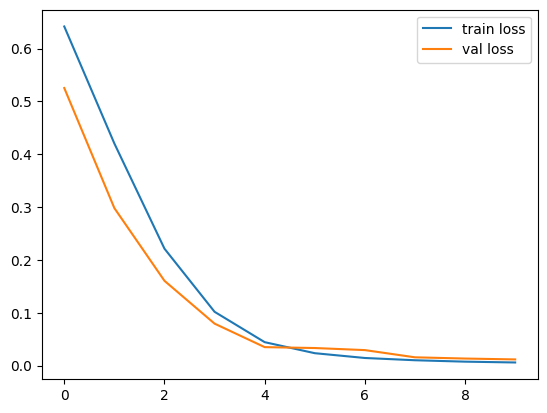

In [40]:
import matplotlib.pyplot as plt

train_losses = [np.mean(i) for i in train_losses]

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# Run on test set

In [43]:
df_true = pd.read_csv('/kaggle/input/test-data/test_data.csv', usecols=['summary'])
df_fake = pd.read_csv('/kaggle/input/test-data/test_data.csv', usecols=['fake_news'])

In [44]:
df_fake['label'] = 0
df_true['label'] = 1
df_fake.head()

,fake_news,label
0,Singapore experienced its coolest winter on re...,0
1,"K-pop sensation, Jimin, is set to embark on a ...",0
2,KFC in Malaysia is launching a limited-edition...,0
3,Vice President Kamala Harris has postponed her...,0
4,"A new initiative, ""Conversations Beyond,"" has ...",0


In [45]:
df_fake = df_fake.rename(columns={'fake_news': 'text'})
df_real = df_true.rename(columns={'summary': 'text'})
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,text,label
0,"K-pop sensation Hyoyeon, also a member of Girl...",0
1,Local fish farms in Singapore face challenges ...,1
2,"In a recent crackdown on tax evasion, Singapor...",0
3,Electoral Boundaries Review Committee (EBRC) n...,1
4,Interest in the Johor-Singapore Special Econom...,1


In [46]:
dataset_test = datasets.Dataset.from_pandas(df)
dataset_test

Dataset({
    features: ['text', 'label'],
    num_rows: 398
})

In [47]:
test_dataset = CustomDataset(dataset_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [48]:
model.load_state_dict(torch.load("best_bert_weights.pt"))

model.eval()
correct_prediction = {}
wrong_prediction = {}
true_labels = []
pred_labels = []


with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0
    for idx, data in enumerate(test_loader):
        if idx % 20 == 0:
            print(f"Processing Batch {idx}")
        features, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

        logits = model(features, attention_mask)
        labels = labels.unsqueeze(1)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        outputs = torch.sigmoid(logits)
        preds = (outputs >= 0.5).float()

        # run this only when dictionaries are empty
        if not correct_prediction and not wrong_prediction:
            for i in range(features.size(0)):
                original_text = data['review_text'][i]
                token_ids = list(map(lambda x: x.item(), data['input_ids'][i]))
                tokens = tokenizer.convert_ids_to_tokens(token_ids)
                raw_logits = logits[i].tolist()
    
                entry = {
                    "original_text": original_text,
                    "tokens_and_id": (tokens, token_ids),
                    "raw_logits": raw_logits,
                    "sigmoid_prob": outputs[i],
                    "true_label": labels[i],
                    "pred_label": preds[i]
                }
    
                if preds[i] == labels[i]:
                    if not correct_prediction:  # Add only one entry.
                        correct_prediction = entry
                else:
                    if not wrong_prediction:  # Add only one entry.
                        wrong_prediction = entry
        total_correct += (preds.squeeze() == labels.squeeze()).sum().item()
        total_samples += labels.size(0)
        pred_labels.extend(preds.squeeze())
        true_labels.extend(labels.squeeze())

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples * 100
        

<ipython-input-48-604183591c41>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_bert_weights.pt"))


Processing Batch 0


In [49]:
print(f"Avg loss: {avg_loss}")
print(f"Test accuracy: {accuracy}")

Avg loss: 0.021489608301115886
Test accuracy: 99.49748743718592


# Get info of correct prediction

In [50]:
correct_prediction['original_text']

'K-pop sensation Hyoyeon, also a member of Girls\' Generation, is set to dazzle audiences in Malaysia on August 17 and 18, 2025, with her highly-anticipated "The Move" concert tour, following the footsteps of her bandmate Taeyeon\'s successful "The Tense" tour, which recently announced stops in Singapore, sparking excitement among fans in Southeast Asia who have been eagerly awaiting new performances from the iconic girl group.'

In [51]:
token_id_list = list(zip(correct_prediction['tokens_and_id'][0], correct_prediction['tokens_and_id'][1]))
len(token_id_list)

512

In [52]:
out = set(token_id_list)
print(sorted(out, key = lambda x:x[1]))

[('[PAD]', 0), ('[CLS]', 101), ('[SEP]', 102), ('"', 1000), ("'", 1005), (',', 1010), ('-', 1011), ('.', 1012), ('a', 1037), ('h', 1044), ('k', 1047), ('s', 1055), ('the', 1996), ('of', 1997), ('and', 1998), ('in', 1999), ('to', 2000), ('is', 2003), ('on', 2006), ('with', 2007), ('from', 2013), ('her', 2014), ('which', 2029), ('have', 2031), ('also', 2036), ('who', 2040), ('been', 2042), ('new', 2047), ('##ing', 2075), ('group', 2177), ('following', 2206), ('##on', 2239), ('august', 2257), ('member', 2266), ('set', 2275), ('band', 2316), ('18', 2324), ('among', 2426), ('17', 2459), ('girl', 2611), ('announced', 2623), ('##5', 2629), ('move', 2693), ('tour', 2778), ('girls', 3057), ('successful', 3144), ('recently', 3728), ('pop', 3769), ('highly', 3811), ('asia', 4021), ('concert', 4164), ('generation', 4245), ('fans', 4599), ('performances', 4616), ('southeast', 4643), ('da', 4830), ('singapore', 5264), ('malaysia', 6027), ('##ye', 6672), ('stops', 6762), ('##yo', 7677), ('excitement'

In [53]:
print(f"Logits: {correct_prediction['raw_logits']} \t \
        Probability after applying sigmoid: {correct_prediction['sigmoid_prob']} \
        \nPred label: {correct_prediction['pred_label']} \t Actual label: {correct_prediction['true_label']}")

Logits: [-5.4803924560546875] 	         Probability after applying sigmoid: tensor([0.0042], device='cuda:0')         
Pred label: tensor([0.], device='cuda:0') 	 Actual label: tensor([0.], device='cuda:0')


# Get info of wrong prediction

In [54]:
wrong_prediction['original_text']

"Dr. Lee Wei Ling to succeed Dr. Ng Yong Kai as CEO of Singapore General Hospital from June 1, 2026, to May 31, 2029. Dr. Lee, with a strong background in medical research and innovation, will oversee the implementation of cutting-edge technologies and expansion of specialty services, building on the hospital's reputation for excellence in patient care. The outgoing CEO, Dr. Ng, who led the hospital since 2020, successfully introduced several key initiatives, including the establishment of a dedicated cancer center and the enhancement of emergency services."

In [55]:
token_id_list = list(zip(wrong_prediction['tokens_and_id'][0], wrong_prediction['tokens_and_id'][1]))
len(token_id_list)

512

In [56]:
out = set(token_id_list)
print(sorted(out, key = lambda x:x[1]))

[('[PAD]', 0), ('[CLS]', 101), ('[SEP]', 102), ("'", 1005), (',', 1010), ('-', 1011), ('.', 1012), ('1', 1015), ('a', 1037), ('s', 1055), ('the', 1996), ('of', 1997), ('and', 1998), ('in', 1999), ('to', 2000), ('as', 2004), ('for', 2005), ('on', 2006), ('with', 2007), ('from', 2013), ('who', 2040), ('may', 2089), ('will', 2097), ('since', 2144), ('including', 2164), ('several', 2195), ('general', 2236), ('june', 2238), ('building', 2311), ('center', 2415), ('led', 2419), ('research', 2470), ('##6', 2575), ('services', 2578), ('##9', 2683), ('care', 2729), ('strong', 2844), ('dr', 2852), ('31', 2861), ('hospital', 2902), ('medical', 2966), ('introduced', 3107), ('key', 3145), ('edge', 3341), ('lee', 3389), ('dedicated', 4056), ('background', 4281), ('cancer', 4456), ('expansion', 4935), ('emergency', 5057), ('establishment', 5069), ('successfully', 5147), ('singapore', 5264), ('ceo', 5766), ('patient', 5776), ('reputation', 5891), ('cutting', 6276), ('technologies', 6786), ('implementat

In [58]:
print(f"Logits: {wrong_prediction['raw_logits']} \t \
        Probability after applying sigmoid: {wrong_prediction['sigmoid_prob']} \
        \nPred label: {wrong_prediction['pred_label']} \t Actual label: {wrong_prediction['true_label']}")

Logits: [5.116376876831055] 	         Probability after applying sigmoid: tensor([0.9940], device='cuda:0')         
Pred label: tensor([1.], device='cuda:0') 	 Actual label: tensor([0.], device='cuda:0')


# Getting F1 Score

In [59]:
!pip install --quiet torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [60]:
from torcheval.metrics.functional import multiclass_f1_score

multiclass_f1_score(torch.tensor(pred_labels), torch.tensor(true_labels), num_classes=2)

tensor(0.9950)

In [61]:
from sklearn.metrics import f1_score

f1_score(list(map(lambda x: x.cpu(), true_labels)), list(map(lambda x: x.cpu(), pred_labels)))

0.995

In [62]:
from sklearn.metrics import classification_report

cls_rep = classification_report(list(map(lambda x: x.cpu(), true_labels)), list(map(lambda x: x.cpu(), pred_labels)))
print(cls_rep)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       199
         1.0       0.99      1.00      0.99       199

    accuracy                           0.99       398
   macro avg       1.00      0.99      0.99       398
weighted avg       1.00      0.99      0.99       398

